### Centaurus A
[TeVCat Gamma-Ray Source Summary](http://tevcat.uchicago.edu/?mode=1;id=122)</br>

[NASA/IPAC Extragalactic Database](https://ned.ipac.caltech.edu/byname?objname=Centaurus+A&hconst=67.8&omegam=0.308&omegav=0.692&wmap=4&corr_z=1)

In [ ]:
# from feupy.scripts.ipynb_to_gallery import convert_ipynb_to_gallery 
# from .core import 

In [1]:
%matplotlib inline

In [124]:
import matplotlib.pyplot as plt # A collection of command style functions

import numpy as np

from astropy import units as u
from astropy.units import  Quantity
from astropy.table import Table, Column
from astropy.coordinates import Angle, SkyCoord

from gammapy.utils.scripts import make_path
from gammapy.modeling.models import Models, LogParabolaSpectralModel, SkyModel, EBLAbsorptionNormSpectralModel

from gammapy.modeling import Fit
from gammapy.datasets import Datasets, FluxPointsDataset


from feupy.utils.string_handling import name_to_txt
from feupy.utils.units import Jy_to_erg_by_cm2_s
from feupy.utils.table import write_tables_csv

from feupy.catalog import CATALOG_REGISTRY
from feupy.plotters import generate_marker_set, setting_leg_style, show_SED
from feupy.target import Target
from feupy.roi import ROI
from feupy.utils.observation import ObservationParameters

from feupy.analysis.config_cntr import CounterpartsConfig
from feupy.analysis.core_cntr import Counterparts
from feupy.analysis.core import Analysis

from core import get_data_VizieR_byname

from feupy.analysis.config import AnalysisConfig
from feupy.analysis.core import Analysis
from feupy.utils.observation import get_obs_label
from feupy.cta.irfs import Irfs

import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from astropy.coordinates import Angle, SkyCoord

from feupy.utils.string_handling import name_to_txt
from feupy.utils.io import mkdir_sub_directory
from feupy.utils.table import write_tables_fits, write_tables_csv
from feupy.utils.datasets import flux_points_dataset_from_table

from feupy.utils.geometry import (
    create_energy_axis, 
    create_pointing, 
    create_pointing_position, 
    create_region_geometry,
    define_on_region,
)

from feupy.analysis.config import AnalysisConfig
from feupy.analysis.core import Analysis
from feupy.utils.observation import get_obs_label
from feupy.cta.irfs import Irfs

from gammapy.maps import MapAxis

from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff, Datasets, FluxPointsDataset

from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker
from gammapy.estimators import FluxPoints, SensitivityEstimator
from gammapy.maps.axes import UNIT_STRING_FORMAT
from gammapy.estimators import FluxPoints

from gammapy.data import Observation
from gammapy.datasets import Datasets

from core import irfs_label_txt, plot_sensitivity_from_table

from gammapy.estimators import FluxPointsEstimator

In [15]:
source_name = 'Cen A'
file_name = name_to_txt(source_name)
redshift = 0.001825
ebl_model_name = 'dominguez'

position = SkyCoord.from_name(source_name)

In [18]:
name_file = name_to_txt(source_name)
outdir = f"./{name_file}"
outdir_path = make_path(outdir)
outdir_path.mkdir(parents=True, exist_ok=True)

datasets_path = make_path(f"{outdir_path}/datasets/")
datasets_path.mkdir(parents=True, exist_ok=True)

tables_path = make_path(f"{outdir}/{name_file}/tables/")
tables_path.mkdir(parents=True, exist_ok=True)

data_path = make_path(f"./data/{name_file}")
data_path.mkdir(parents=True, exist_ok=True)

figures_path = make_path(f"{outdir}/figures/")
figures_path.mkdir(parents=True, exist_ok=True)

config = CounterpartsConfig()

config.general.outdir = outdir
config.general.datasets_file = f"{datasets_path}/datasets.yaml"
config.general.models_file = f"{datasets_path}/models.yaml"

In [ ]:
CATALOG_REGISTRY

In [ ]:
source_name = 'Cen A'
catalog = CATALOG_REGISTRY.get_cls("gamma-cat")()
source = catalog[source_name]
print(source.info())

In [93]:
target = Target(
    name=source_name, 
    pos_ra=position.ra, 
    pos_dec=position.dec
)

radius_roi = 0.5 * u.Unit("deg")

roi = ROI(target=target, radius=radius_roi)

config.roi = roi.dict
config.roi.catalogs = "all"

# e_edges_min= 1e5*u.MeV 
# config.energy_range.min = e_edges_min

analysis = Counterparts(config)
analysis.run()
analysis.df_sep

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}


SourceCatalogGammaCat:
    name: gamma-cat
    description: An open catalog of gamma-ray sources
    sources: 162

SourceCatalogHGPS:
    name: hgps
    description: H.E.S.S. Galactic plane survey (HGPS) source catalog
    sources: 78

SourceCatalog2HWC:
    name: 2hwc
    description: 2HWC catalog from the HAWC observatory
    sources: 40

SourceCatalog3FGL:
    name: 3fgl
    description: LAT 4-year point source catalog
    sources: 3034

SourceCatalog4FGL:
    name: 4fgl
    description: LAT 8-year point source catalog
    sources: 6659

SourceCatalog2FHL:
    name: 2fhl
    description: LAT second high-energy source catalog
    sources: 360

SourceCatalog3FHL:
    name: 3fhl
    description: LAT third high-energy source catalog
    sources: 1556

SourceCatalog3HWC:
    name: 3hwc
    description: 3HWC catalog from the HAWC observatory
    sources: 65

SourceCatalogExtraHAWC:
    name: extraHAWC
    description: extraHAWC catalog from the HAWC observatory
    sources: 8

SourceCatal

,Source name,RA(deg),dec.(deg),Sep.(deg)
0,3FGL J1325.4-4301,201.366592,-43.030499,0.011441
1,4FGL J1325.5-4300,201.381302,-43.016499,0.012157
2,2FHL J1325.6-4301,201.423004,-43.026600,0.043016
3,3FHL J1325.5-4300,201.376862,-43.013069,0.010533


In [95]:
models = Models()
datasets = Datasets()

datasets.extend(analysis.datasets)
models.extend(datasets.models)

In [96]:
datasets.write(
    filename=f'{datasets_path}/datasets_HE.yaml', 
    filename_models=f'{datasets_path}/models_HE.yaml', 
    overwrite=True)

In [97]:
datasets_HE = Datasets.read(filename=f'{datasets_path}/datasets_HE.yaml', filename_models=f'{datasets_path}/models_HE.yaml')

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


In [98]:
xaxis_label = r'$\rm{E\ [MeV] }$'
xaxis_units = u.Unit('MeV')

yaxis_label = r'$\rm{E^2\ J(E)\ [erg\ cm^{-2}\ s^{-1}] }$'
yaxis_units = u.Unit('erg cm-2 s-1')

energy_bounds = [1e1, 1e7] * u.MeV
ylim = [1e-15, 1e-8]

leg_place = dict(
#     bbox_to_anchor = (1, 0.5), # Set legend outside plot
#     ncol=1, 
    loc='upper left', 
)
markers = generate_marker_set(datasets.names, 5)

4 unique markers generated


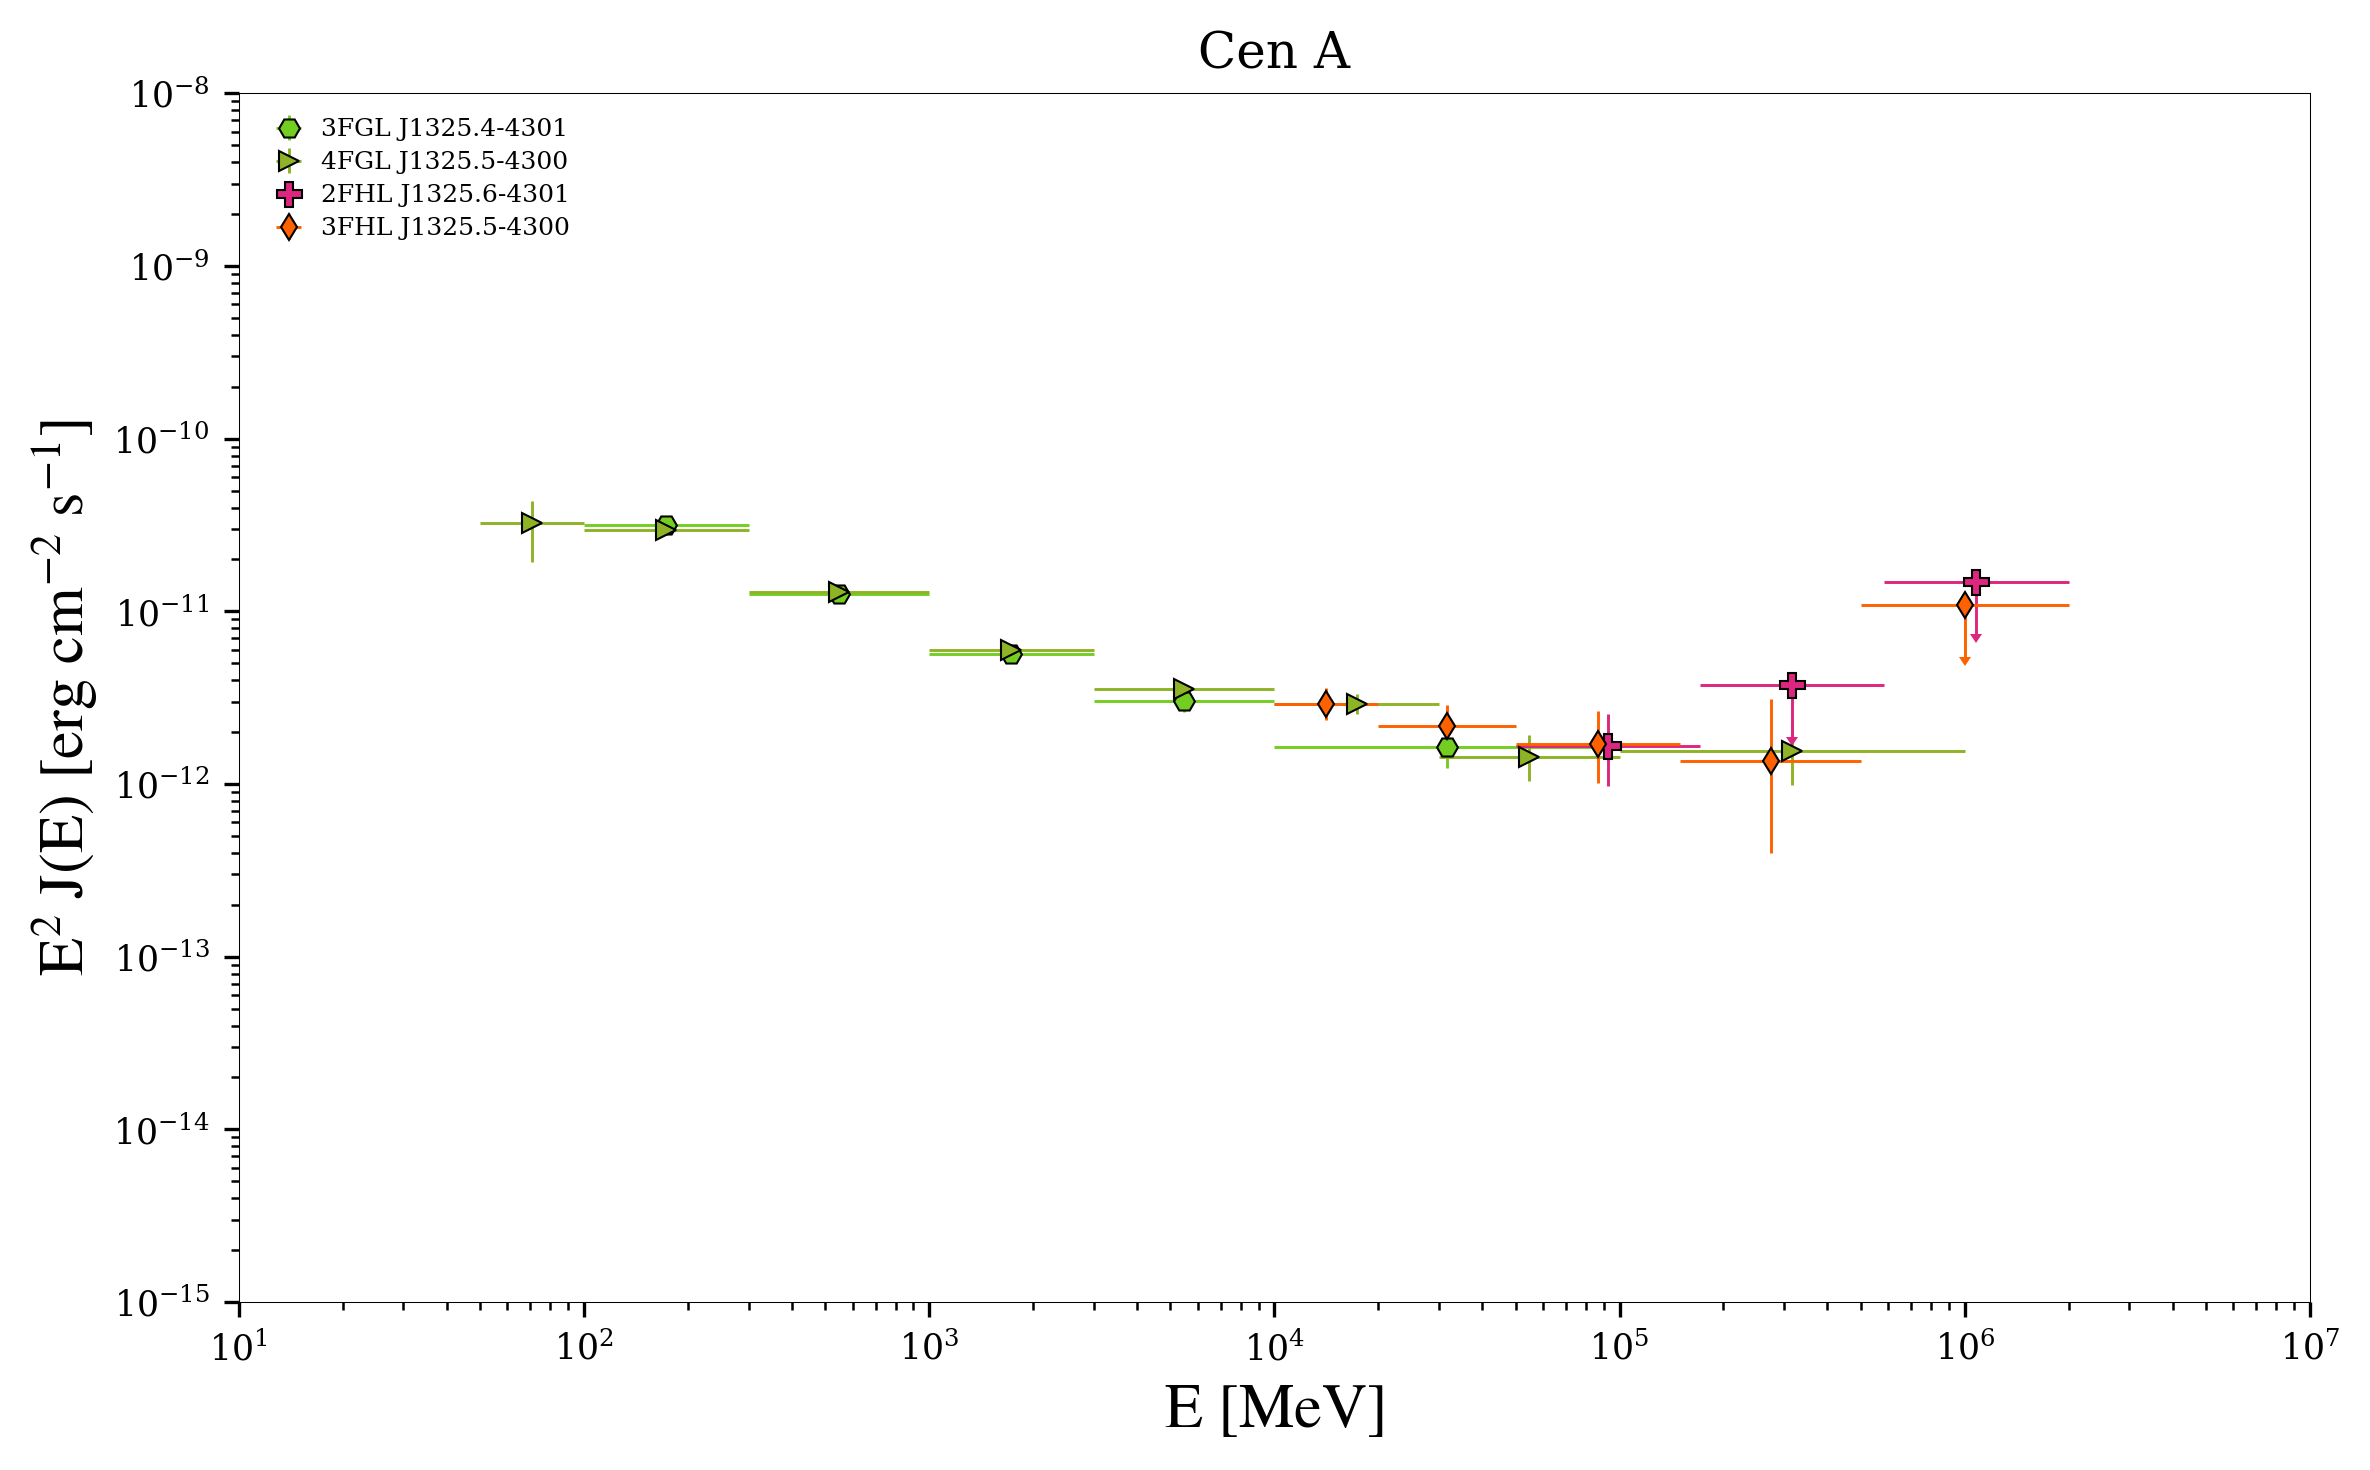

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for index, d in enumerate(datasets):
    marker=markers['marker'][index] 
    label=markers['label'][index] 
    markersize=markers['markersize'][index] 
    color=markers['color'][index] 

    d.data.plot(
        label=d.name, 
        c=color,
        marker=marker,
        markersize=markersize,
        ls='None',
        mec='k',
        mew=0.5,
        elinewidth=0.7,
        capsize=1.5,
        **kwargs
    )
    
# model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
# model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.yaxis.set_units(yaxis_units)
ax.xaxis.set_units(xaxis_units)

ax.set_xlabel(xaxis_label)
ax.set_ylabel(yaxis_label)

ax.set_xlim(energy_bounds)
ax.set_ylim(ylim)

ax.legend(**leg_place)

plt.title(f"{source_name}")

# plt.savefig(f"{figures_path}/SED_HE_{name_file}")
plt.show()

In [100]:

table= Table.read(f'{data_path}/SED.csv', format='ascii')
table

Frequency,e2dnde,e2dnde_err,e_ref
float64,float64,float64,float64
3.22e+22,3.59e-11,8.69e-13,133168499.840948
5.7e+22,2.7e-11,6.88e-13,235733058.72466
1.01e+23,1.74e-11,5.6e-13,417702437.38931
1.79e+23,1.05e-11,4.55e-13,740284517.749371
3.17e+23,7.54e-12,4.21e-13,1311006659.92486
5.62e+23,4.65e-12,3.94e-13,2324245245.67121
...,...,...,...
1.13e+26,3.11e-13,8.7e-14,467330449752.396
1.65e+26,3.55e-13,6.7e-14,682385169992.437


In [101]:
table['Frequency'].unit = 'Hz'
table['e2dnde'].unit = 'erg s-1 cm-2'
table['e2dnde_err'].unit = 'erg s-1 cm-2'
table.meta['reference'] = 'https://www.mpi-hd.mpg.de/HESS/pages/publications/auxiliary/auxinfo_CenA_Extension.html'

In [106]:
def Hz_to_TeV(data_freq=None):
    return Quantity(data_freq).to(u.eV, equivalencies=u.spectral())
data = Hz_to_TeV(table['Frequency'])
table['e_ref'] = Column(
    data=data,
    description='energy of reference', unit=data[0].unit, format='.3e',
)

In [107]:
write_tables_csv(table, data_path, 'SED')

In [108]:
flux_points = FluxPoints.from_table(table) 
dataset = FluxPointsDataset(data=flux_points)

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.


<Axes: xlabel='Energy [$\\mathrm{eV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

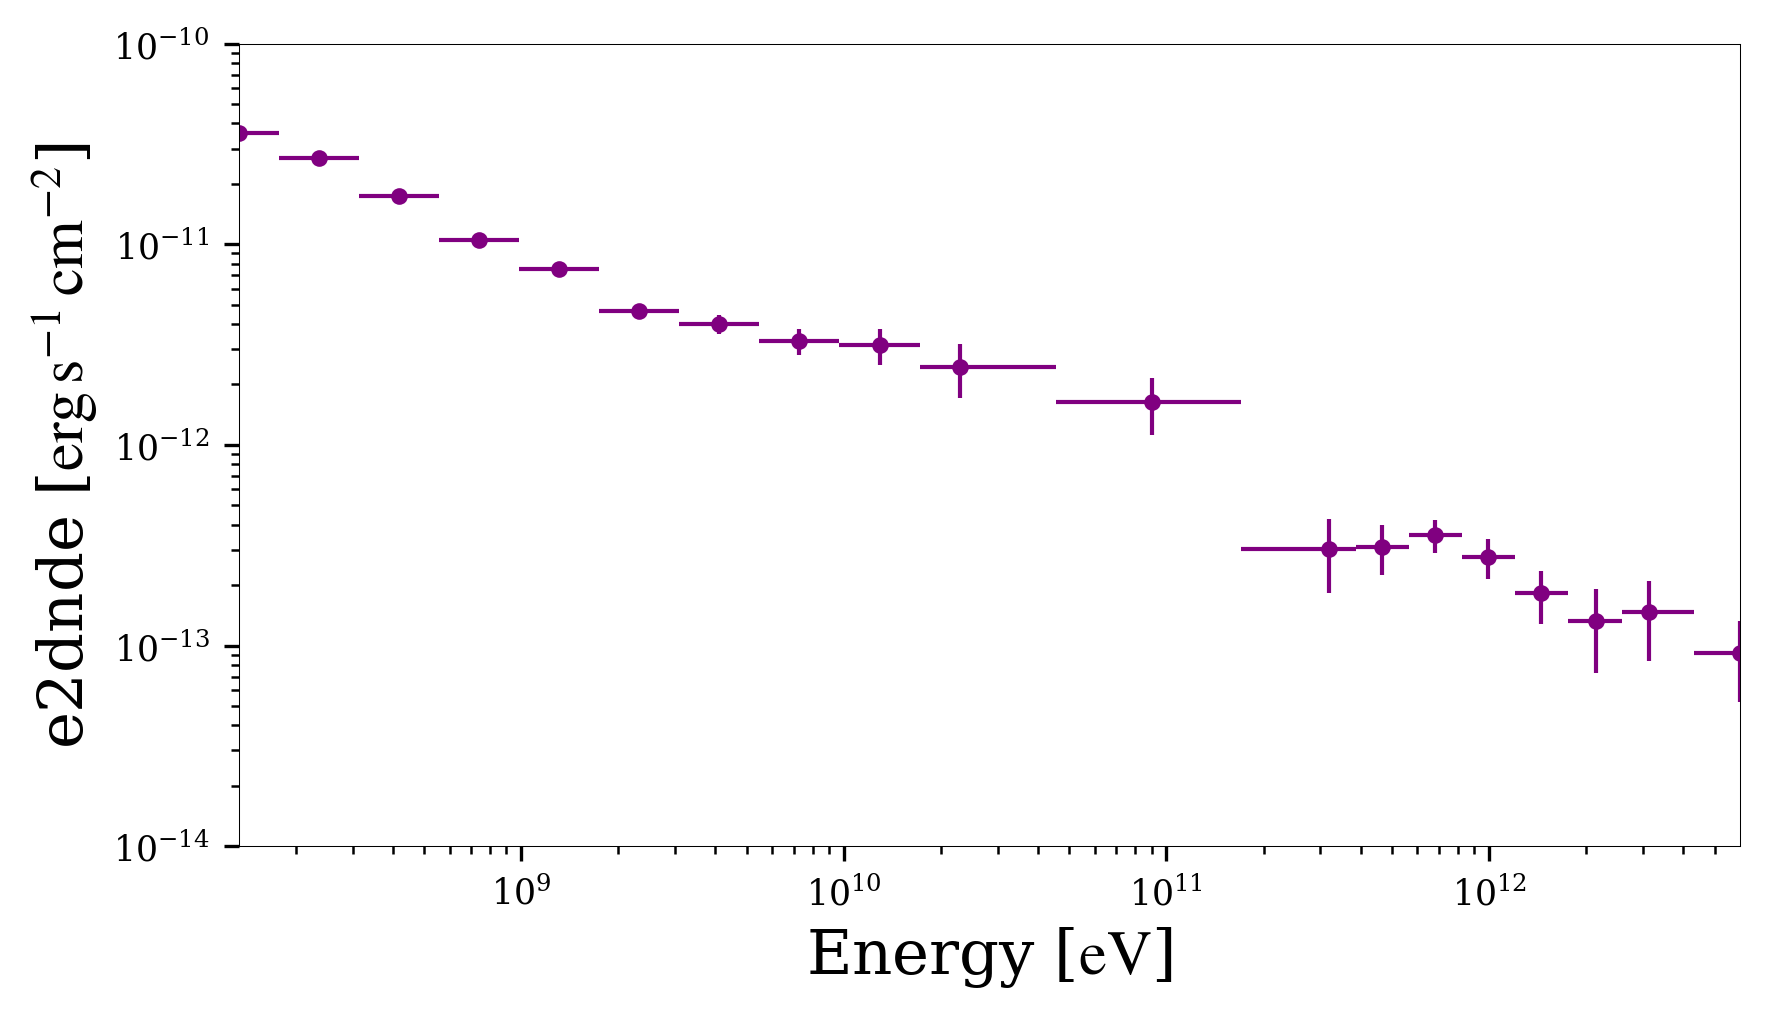

In [109]:
dataset.data.plot()

In [105]:
table

Frequency,e2dnde,e2dnde_err,e_ref
Hz,erg / (s cm2),erg / (s cm2),eV
float64,float64,float64,float64
3.22e+22,3.59e-11,8.69e-13,1.332e+08
5.7e+22,2.7e-11,6.88e-13,2.357e+08
1.01e+23,1.74e-11,5.6e-13,4.177e+08
1.79e+23,1.05e-11,4.55e-13,7.403e+08
3.17e+23,7.54e-12,4.21e-13,1.311e+09
5.62e+23,4.65e-12,3.94e-13,2.324e+09
...,...,...,...
1.65e+26,3.55e-13,6.7e-14,6.824e+11


In [ ]:
dataset = FluxPointsDataset.read(filename)

In [ ]:
table['e_ref'] = table['Frequency'].to()

In [ ]:
===================================================================================
    	    SED points derived from the H.E.S.S. and Fermi-LAT data
===================================================================================
Frequency (GHz) nuFnu (erg/s/cm^2) 1-sigma error on nuFnu (erg/s/cm^2)
3.22e22 3.5863e-11 8.6867e-13
5.70e22 2.7028e-11 6.877e-13
1.01e23 1.7362e-11 5.5987e-13
1.79e23 1.0478e-11 4.5481e-13
3.17e23 7.541e-12 4.2118e-13
5.62e23 4.6483e-12 3.9434e-13
9.95e23 3.9974e-12 4.4868e-13
1.76e24 3.2905e-12 4.9514e-13
3.12e24 3.1527e-12 6.5024e-13
5.53e24 2.4494e-12 7.4173e-13
2.18e25 1.6405e-12 5.2581e-13
7.73e25 3.04e-13 1.22e-13
1.13e26 3.11e-13 8.70e-14
1.65e26 3.55e-13 6.7e-14
2.40e26 2.77e-13 6.3e-14
3.51e26 1.82e-13 5.4e-14
5.17e26 1.32e-13 5.9e-14
7.56e26 1.47e-13 6.3e-14
1.45e27 9.20e-14 4.0e-14

In [ ]:
spectral_model = LogParabolaSpectralModel()

In [ ]:
# spectral_model = model_int.spectral_model
# spatial_model = models[1].spatial_model

model = SkyModel(
#     spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-fit",
)
models.append(model)

In [ ]:
display(model.parameters.to_table())

In [ ]:
spectral_model = model.spectral_model.beta
model.spectral_model.beta.min = 0.0
model.spectral_model.amplitude.max = 1e-12


In [ ]:
model.spectral_model.beta

In [ ]:
datasets.models = model
fitter = Fit()
result_fit = fitter.run(datasets=datasets)
display(model.parameters.to_table())

In [ ]:
energy_bounds = [1e1, 1e7] * u.MeV
ylim = [1e-15, 1e-8]

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for index, d in enumerate(datasets):
    marker=markers['marker'][index] 
    label=markers['label'][index] 
    markersize=markers['markersize'][index] 
    color=markers['color'][index] 

    d.data.plot(
        label=d.name, 
        c=color,
        marker=marker,
        markersize=markersize,
        ls='None',
        mec='k',
        mew=0.5,
        elinewidth=0.7,
        capsize=1.5,
        **kwargs
    )
    
model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)
ax.yaxis.set_units(yaxis_units)
ax.xaxis.set_units(xaxis_units)

ax.set_xlabel(xaxis_label)
ax.set_ylabel(yaxis_label)

ax.set_xlim(energy_bounds)
ax.set_ylim(ylim)

ax.legend(**leg_place)

plt.title(f"{source_name}")

plt.savefig(f"{figures_path}/SED_HE_{name_file}")
plt.show()


In [ ]:
display(model.parameters.to_table())

In [ ]:
datasets.models = model

In [ ]:
# config.read(config.general.config_file)

In [ ]:
datasets.write(filename=config.general.datasets_file, filename_models=config.general.models_file, overwrite=True)

In [ ]:
file = f'{data_path}/table_photandseds.csv'
table = Table.read(file)
datasets_VizieR = get_data_VizieR_byname(table)

In [116]:
datasets.names

['3FGL J1325.4-4301',
 '4FGL J1325.5-4300',
 '2FHL J1325.6-4301',
 '3FHL J1325.5-4300',
 'Dh8TEx1b']

In [ ]:
datasets = Datasets(datasets_VizieR)
datasets.extend(datasets_HE)

In [113]:
xaxis_label = r'$\rm{E\ [TeV] }$'
xaxis_units = u.Unit('TeV')

yaxis_label = r'$\rm{E^2\ J(E)\ [erg\ cm^{-2}\ s^{-1}] }$'
yaxis_units = u.Unit('erg cm-2 s-1')

energy_bounds = [1e-22, 1e3] * u.TeV
ylim = [1e-16, 1e-6]

leg_place = dict(
#     bbox_to_anchor = (1, 0.5), # Set legend outside plot
#     ncol=1, 
    loc='upper left', 
)
markers = generate_marker_set(datasets.names, 5)

5 unique markers generated


In [120]:
energy_bounds = [1e-7, 1e14] * u.eV


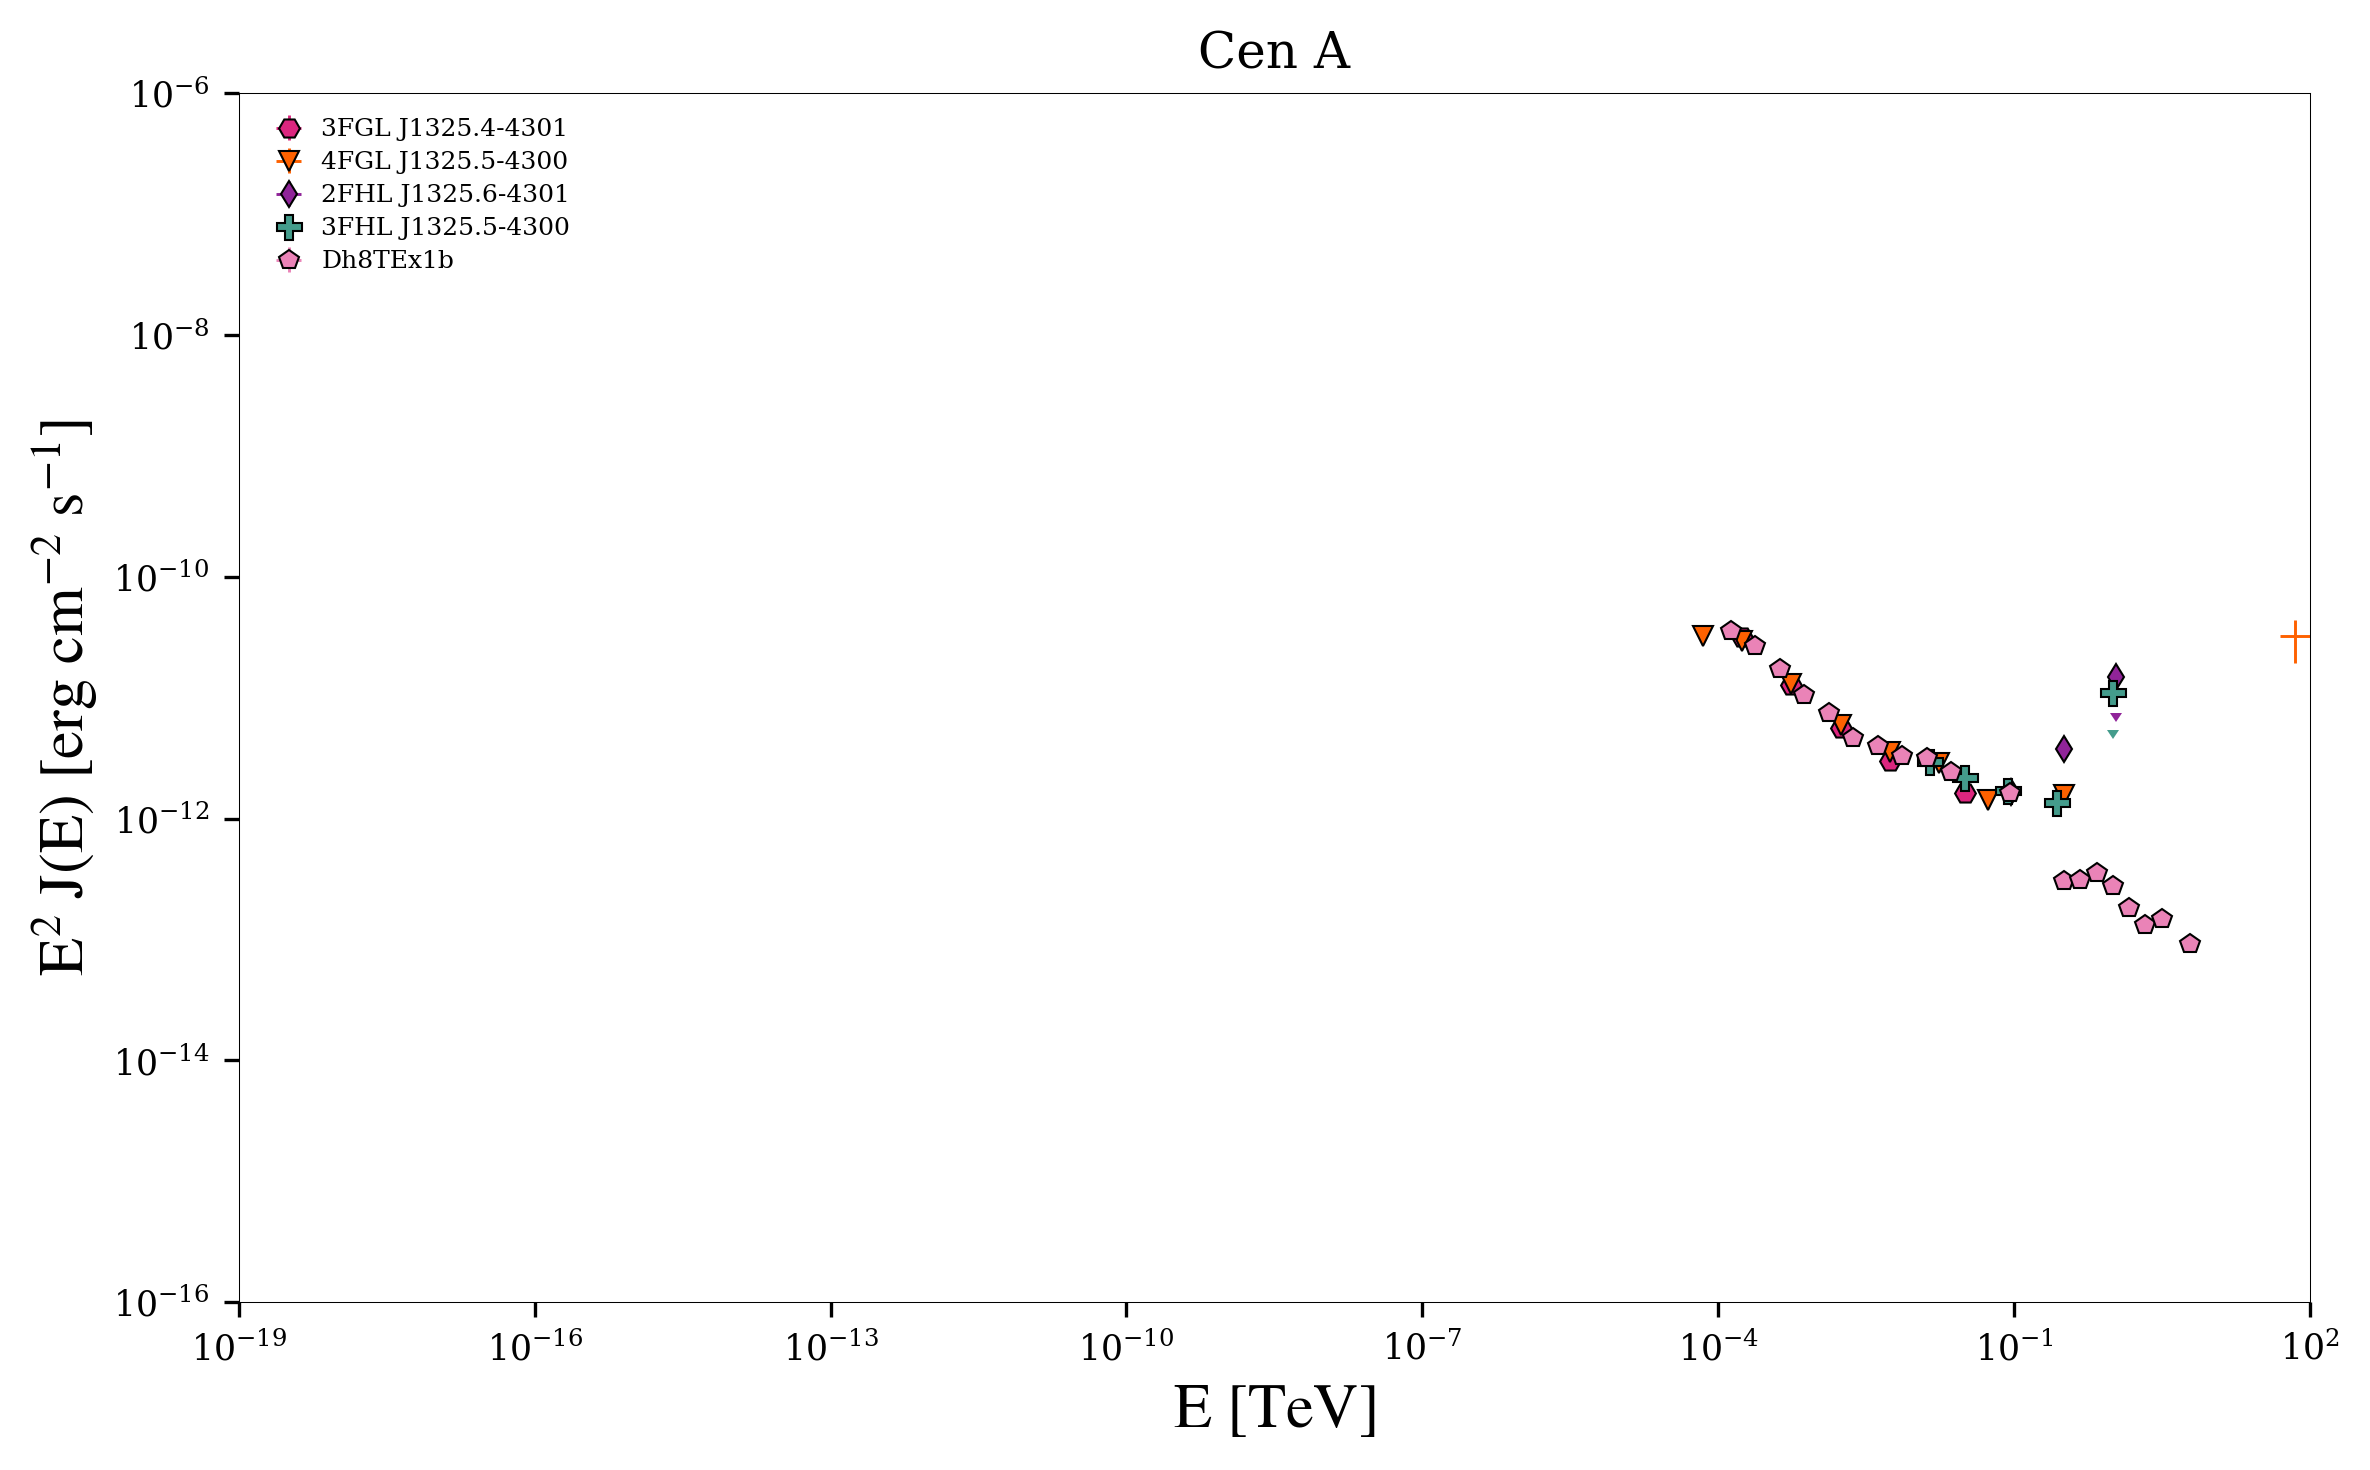

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for index, d in enumerate(datasets):
    marker=markers['marker'][index] 
    label=markers['label'][index] 
    markersize=markers['markersize'][index] 
    color=markers['color'][index] 
    label=d.name
#     if  label.find('FHL ') == -1:
#         if label.find('FGL ') == -1:
#             label = None
            
    d.data.plot(
        label=label, 
        c=color,
        marker=marker,
        markersize=markersize,
        ls='None',
        mec='k',
        mew=0.5,
        elinewidth=0.7,
        capsize=1.5,
        **kwargs
    )
    
# model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
# model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.yaxis.set_units(yaxis_units)
ax.xaxis.set_units(xaxis_units)

ax.set_xlabel(xaxis_label)
ax.set_ylabel(yaxis_label)

ax.set_xlim(energy_bounds)
ax.set_ylim(ylim)

ax.legend(**leg_place)

plt.title(f"{source_name}")

plt.savefig(f"{figures_path}/flux_points_VizieR_{name_file}")
plt.show()

In [127]:
leg_style = {}
leg_style = setting_leg_style(leg_style, names=datasets.names)

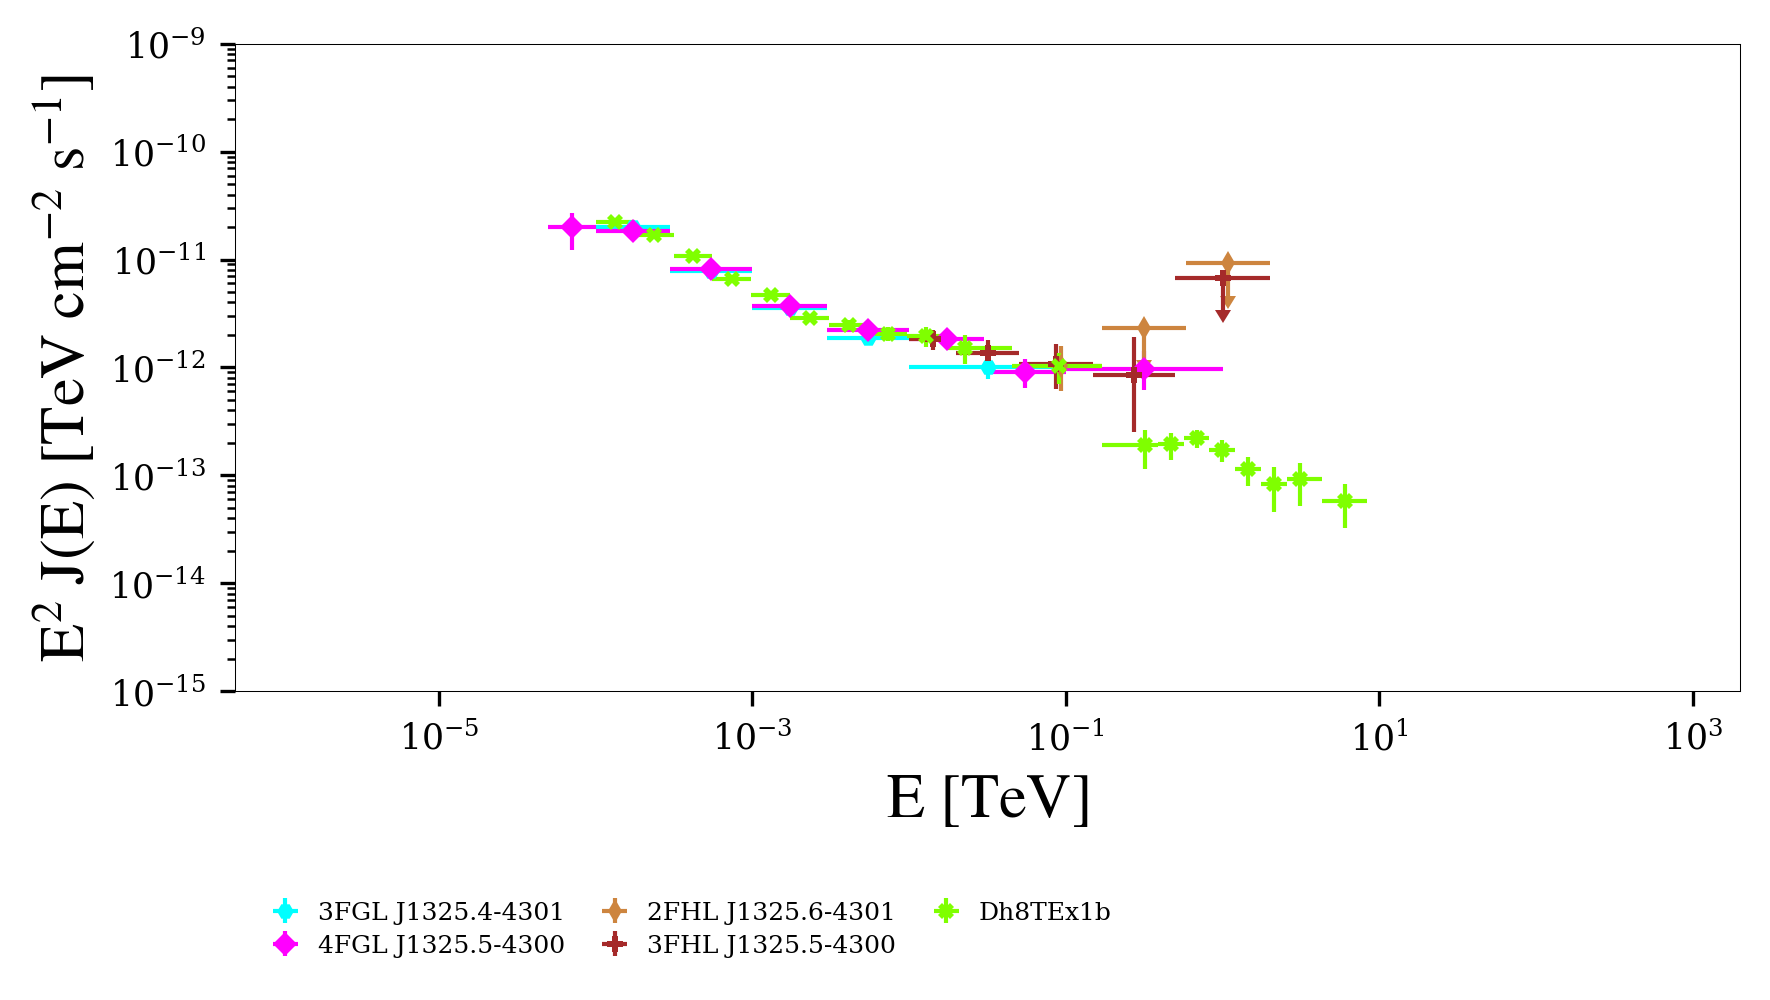

In [129]:
plot_limits = dict(
    energy_bounds = [5e-7, 2e3] * u.TeV,
    ylim = [1e-15, 1e-9]
)


show_SED(
    datasets=datasets, 
#     models=analysis.models,
    leg_style=leg_style,
    plot_limits=plot_limits,
    file_path=f"{figures_path}/flux_points_all_couterparts")

In [ ]:
config =  AnalysisConfig()
config.general.outdir = outdir
config.general.datasets_file = f"{datasets_path}/datasets.yaml"
config.general.models_file = f"{datasets_path}/models.yaml"
analysis = Analysis(config)

In [ ]:
pointing_angle = 0*u.deg
offset = 0.5*u.deg

on_region_radius = Angle("0.11 deg")

gamma_min = 10
n_sigma = 5 
bkg_syst_fraction = 0.10

selection = ["edisp", "background", "exposure"]

containment = 0.68

acceptance = 1
acceptance_off = 20

e_edges_min = 1.0e-01*u.TeV
e_edges_max = 3.2e+01*u.TeV
nbin_edges = 12

In [ ]:
irfs_opt = ['North', 'AverageAz', '20deg', '0.5h']
livetime = 200 * u.h

obs_param = ObservationParameters(livetime, offset, pointing_angle, irfs_opt)

In [ ]:
config.datasets.on_region = target.dict['position']
config.datasets.on_region.radius  = on_region_radius

config.observation.pointing_angle = pointing_angle
config.observation.offset = offset
config.observation.livetime = livetime
config.observation = obs_param.dict
config.observation.target = target.dict

config.onoff.acceptance = acceptance
config.onoff.acceptance_off = acceptance_off

In [ ]:
pointing_position = create_pointing_position(position, pointing_angle, offset)
pointing = create_pointing(pointing_position)
print(f"{pointing}\n")

on_region = define_on_region(center=position, radius=on_region_radius)
print(f"{on_region}\n")


config.datasets.geom.axes.energy.min = e_edges_min
config.datasets.geom.axes.energy.max = e_edges_max
config.datasets.geom.axes.energy.nbins = nbin_edges
config.datasets.geom.axes.energy.name = 'energy'
energy_settings = config.datasets.geom.axes.energy

config.datasets.geom.axes.energy_true.min =  3.2e-02*u.TeV
config.datasets.geom.axes.energy_true.max = 1.0e+02*u.TeV
config.datasets.geom.axes.energy_true.nbins = 15
config.datasets.geom.axes.energy_true.name = 'energy_true'
energy_true_settings = config.datasets.geom.axes.energy_true

energy_axis = create_energy_axis(
    energy_settings.min, 
    energy_settings.max, 
    energy_settings.nbins, 
    per_decade=True, 
    name=energy_settings.name
)

geom = create_region_geometry(on_region, axes=[energy_axis])
print(geom)
print(energy_axis)

energy_axis_true = create_energy_axis(
    energy_true_settings.min, 
    energy_true_settings.max, 
    energy_true_settings.nbins, 
    per_decade=True, 
    name=energy_true_settings.name
)


empty_dataset = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true, name='empty_dataset')
# analysis.datasets = Datasets(empty_dataset)
print(empty_dataset)

In [ ]:
spectrum_maker = SpectrumDatasetMaker(selection=selection)
sensitivity_estimator = SensitivityEstimator(
    gamma_min=gamma_min, n_sigma=n_sigma, bkg_syst_fraction=bkg_syst_fraction
)
sensitivity_estimator1 = SensitivityEstimator(
    gamma_min=gamma_min, n_sigma=n_sigma, bkg_syst_fraction=bkg_syst_fraction
)

In [ ]:

irfs_config =[
    ['South', 'South-SSTSubArray','South-MSTSubArray','North','North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(irfs_config)

datasets = Datasets()
for i, (irfs_opt, irfs, irfs_label, location) in enumerate(zip(irfs_opts, irfss, irfs_labels, locations)):
    obs = Observation.create(
        pointing=pointing, irfs=irfs, livetime=livetime, location=location
    )
    print(obs)
    obs_label = get_obs_label(irfs_opt, offset, on_region_radius, livetime)
    print(obs_label)
    dataset = spectrum_maker.run(empty_dataset, obs)
    print(dataset)

    # correct exposure
    print('correct exposure')
    dataset.exposure *= containment
    print(dataset)

    # correct background estimation
    print('correct background estimation')
    on_radii = obs.psf.containment_radius(
        energy_true=energy_axis.center, 
        offset=offset, 
        fraction=containment
    )
    factor = (1 - np.cos(on_radii)) / (1 - np.cos(geom.region.radius))
    dataset.background *= factor.value.reshape((-1, 1, 1))
    print(dataset)

    print('create SpectrumDatasetOnOff')
    dataset_on_off = SpectrumDatasetOnOff.from_spectrum_dataset(
        dataset=dataset, acceptance=acceptance, acceptance_off=acceptance_off
    )
    print(dataset_on_off)

    sensitivity_table = sensitivity_estimator.run(dataset_on_off)
    sensitivity_table.meta['source'] = source_name
    sensitivity_table.meta["offset"] = offset.to_string()
    sensitivity_table.meta["on_region_radius"] = f'{on_region_radius.deg}deg'
    sensitivity_table.meta["livetime"] = livetime.to_string()    
    sensitivity_table.meta["site"] = irfs_opt[0]
    sensitivity_table.meta["azimuth-averaged "] = irfs_opt[1]
    sensitivity_table.meta["zenith-angle"] = u.Quantity(irfs_opt[2]).to_string()
    sensitivity_table.meta["obs_time"] = u.Quantity(irfs_opt[3]).to_string()
    sensitivity_table.meta['irfs_label'] = irfs_label
    sensitivity_table.meta['irfs_config'] = irfs_opt
    sensitivity_table["on_radii"] = on_radii
    sensitivity_table["on_radii"].format = '.3e'
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    label_dataset = f'sens {obs_label}'
    sensitivity_dataset = flux_points_dataset_from_table(sensitivity_table, name=label_dataset)
    datasets.append(sensitivity_dataset)
    print(sensitivity_table)
    print(dataset_on_off)

    dataset_on_off1 = dataset_on_off.to_image()

    sensitivity_table1 = sensitivity_estimator1.run(dataset_on_off1)
    print(sensitivity_table1)

    # To get the integral flux, we convert to a `FluxPoints` object that does the conversion
    # internally
    flux_points = FluxPoints.from_table(
        sensitivity_table1, sed_type="e2dnde", reference_model=sensitivity_estimator1.spectrum
    )
    int_sens = np.squeeze(flux_points.flux.quantity)
    print(
        f"Integral sensitivity in {livetime:.2f} above {e_edges_min:.2e} "
        f"is {int_sens:.2e}"
    )
    sensitivity_table.meta['int_sens'] = int_sens.to_string()    
    write_tables_csv(
        sensitivity_table, tables_path, f"{label_table}_{livetime.to_string().replace(' h', 'h')}")

In [ ]:
tables_south = [] 
tables_south_names = []

_irfs =[
    ['South'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_SOUTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_SOUTH):
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    filename = f"{label_table}_{livetime.to_string().replace(' h', 'h')}.csv"
    table = Table.read(f'{tables_path}/{filename}', format='ascii')
    tables_south_names.append(table.meta['irfs_label'])
    tables_south.append(table)

markers_south = generate_marker_set(tables_south_names, 2.5)

tables_north = [] 
tables_north_names = []

_irfs =[
    ['North'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_NORTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_NORTH):
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    filename = f"{label_table}_{livetime.to_string().replace(' h', 'h')}.csv"
    table = Table.read(f'{tables_path}/{filename}', format='ascii')
    tables_north_names.append(table.meta['irfs_label'])
    tables_north.append(table)

markers_north = generate_marker_set(tables_north_names, 2.5)

linestyle = ['solid', (0, (5, 1)), (0, (3, 5, 1, 5))]


In [ ]:
energy_bounds = [e_edges_min, e_edges_max]
ylim = [1e-16, 1e-6]

fig, ax = plt.subplots()
ax.set_prop_cycle(color=['blue', 'blue', 'blue'], linestyle=linestyle)

kwargs = {'ax': ax,
         'sed_type': 'e2dnde'}

for index, (table, label) in enumerate(zip(tables_south, tables_south_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    ax = plot_sensitivity_from_table(table, wich='e2dnde',  ax=ax, label=label)

ax.set_prop_cycle(color=['green', 'green', 'green'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_north, tables_north_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    ax = plot_sensitivity_from_table(table,wich='e2dnde', ax=ax, label=label)
    
model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.legend(loc="best", scatterpoints=1, handlelength = 3, fontsize=6)

plt.savefig(fname = f"/home/born-again/Documents/GitHub/radio_galaxies/figures/{name_file}_sites.png")

In [ ]:
tables_south = [] 
tables_south_names = []

_irfs =[
    ['South', 'South-SSTSubArray', 'South-MSTSubArray'], 
    ['AverageAz'], 
    ['40deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_SOUTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_SOUTH):
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    filename = f"{label_table}_{livetime.to_string().replace(' h', 'h')}.csv"
    table = Table.read(f'{tables_path}/{filename}', format='ascii')
    tables_south_names.append(table.meta['irfs_label'])
    tables_south.append(table)

markers_south = generate_marker_set(tables_south_names, 2.5)

tables_north = [] 
tables_north_names = []

_irfs =[
    ['North', 'North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['40deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_NORTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_NORTH):
    label_table = f'sens-{irfs_label_txt(irfs_opt)}'
    filename = f"{label_table}_{livetime.to_string().replace(' h', 'h')}.csv"
    table = Table.read(f'{tables_path}/{filename}', format='ascii')
    tables_north_names.append(table.meta['irfs_label'])
    tables_north.append(table)

markers_north = generate_marker_set(tables_north_names, 2.5)

fig, ax = plt.subplots()

kwargs = {'ax': ax,
         'sed_type': 'e2dnde'}
ax.set_prop_cycle(color=['blue', 'blue', 'blue'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_south, tables_south_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    ax = plot_sensitivity_from_table(table, wich='e2dnde',  ax=ax, label=label)

ax.set_prop_cycle(color=['green', 'green', 'green'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_north, tables_north_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    
    ax = plot_sensitivity_from_table(table,wich='e2dnde', ax=ax, label=label)

model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.legend(loc="best", scatterpoints=1, handlelength = 3, fontsize=6)
plt.savefig(fname = f"/home/born-again/Documents/GitHub/radio_galaxies/figures/{name_file}_subarrays.png")


In [ ]:
model_intrinsic = model.spectral_model.copy()
print(model_intrinsic)

In [ ]:
ebl = EBLAbsorptionNormSpectralModel.read_builtin("dominguez", redshift=redshift)

spectral_model = ebl * model_intrinsic
spatial_model = model.spatial_model
model_simu = SkyModel(spectral_model=spectral_model, 
                      spatial_model=spatial_model,
                      name="model-simu")
display(model_simu.parameters.to_table())

In [ ]:
target = Target(
    name=source_name, 
    pos_ra=position.ra, 
    pos_dec=position.dec,
    spectral_model=model_intrinsic,
    redshift = redshift,
    ebl_model_name= "dominguez",
)

print(target)

In [ ]:
n_obs = 10
map_selection = ["edisp", "background", "exposure"]
methods = ["bkg-peak"]
parameters = {'aeff_percent': 10}
containment_correction = False
use_region_center = False  

config.datasets.map_selection = map_selection
config.datasets.safe_mask.parameters = parameters
config.datasets.safe_mask.methods = methods
config.datasets.containment_correction = containment_correction
config.datasets.use_region_center = use_region_center
config.statistics.n_obs = n_obs

In [ ]:
irfs_opt = ['North', 'AverageAz', '20deg', '50h']

config.flux_points.source = target.name
config.flux_points.energy.nbins = config.datasets.geom.axes.energy.nbins
config.flux_points.energy.max = config.datasets.geom.axes.energy.max 
config.flux_points.energy.min = config.datasets.geom.axes.energy.min 

analysis = Analysis(config)
observation = analysis.create_observation()
reference_dataset = analysis.create_reference_dataset()
spectrum_dataset = analysis.simulate_spectrum(observation, reference_dataset, model.copy(name='source'))
dataset_on_off = analysis.make_on_off(spectrum_dataset)

In [ ]:
plt.figure()
ax_spectrum, ax_residuals = dataset_on_off.plot_fit()

In [ ]:
simulated_datasets = analysis.run_on_off(spectrum_dataset, dataset_on_off)
simulated_datasets.models = [model.copy('source')]

In [ ]:
results = []
fit = Fit()
for dataset in simulated_datasets.copy():
    # Do the 3D fit
    model_fit = model.copy(name="model-simu")
    spectral_model = model_fit.spectral_model
#     spectral_model.lambda_.min = 0
    dataset.models = [model_fit]

    fit_result = fit.run([dataset])

    if fit_result.success:
        _par_dict = {}
        _par_dict["irfs_opt"] = f'{irfs_opt}'
        _par_dict["success"] = fit_result.success

        for par in fit_result.parameters.free_parameters:
            _par_dict[par.name] = par.quantity

        sp_model = fit_result.models["model-simu"].spectral_model
#         Ec = 1./sp_model.lambda_.quantity
#         err = Ec**2 * sp_model.lambda_.error / u.TeV
#         _par_dict["ecut"] = Ec
#         _par_dict["ecut_err"] = err
        results.append(_par_dict)


# results_all.append(results)

In [ ]:
flux_points_settings = analysis.config.flux_points
energy_settings = flux_points_settings.energy

In [ ]:
energy_edges = MapAxis.from_energy_bounds(
    energy_settings.min,
    energy_settings.max, 
    nbin=energy_settings.nbins).edges

fpe = FluxPointsEstimator(
    energy_edges=energy_edges, 
    source='source', 
    selection_optional="all"
)
flux_points = fpe.run(datasets=simulated_datasets)

In [ ]:
flux_points.plot()
dataset_cta = FluxPointsDataset(models=model_fit, data=flux_points, name=Irfs.get_irfs_label(irfs_opt))
dataset_cta.plot_fit()

In [ ]:
datasets = Datasets(datasets_HE)
datasets.append(dataset_cta)
markers = generate_marker_set(datasets.names, 5)

In [ ]:
energy_bounds = [1e-7, 1e2]*u.TeV
energy_bounds

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for index, d in enumerate(datasets):
    marker=markers['marker'][index] 
    label=markers['label'][index] 
    markersize=markers['markersize'][index] 
    color=markers['color'][index] 
    label=d.name
#     if  label.find('FHL ') == -1:
#         if label.find('FGL ') == -1:
#             label = None
            
    d.data.plot(
        label=label, 
        c=color,
        marker=marker,
        markersize=markersize,
        ls='None',
        mec='k',
        mew=0.5,
        elinewidth=0.7,
        capsize=1.5,
        **kwargs
    )
    
model.spectral_model.plot(energy_bounds=energy_bounds, label=model.name, color="k", **kwargs)
# model.spectral_model.plot_error(energy_bounds=energy_bounds, **kwargs)

ax.yaxis.set_units(yaxis_units)
ax.xaxis.set_units(xaxis_units)

ax.set_xlabel(xaxis_label)
ax.set_ylabel(yaxis_label)

ax.set_xlim(energy_bounds)
ax.set_ylim(ylim)

ax.legend(**leg_place)

plt.title(f"{source_name}")

plt.savefig(f"{figures_path}/SED_CTA_{name_file}")
plt.show()

In [ ]:
# !jupyter nbconvert counterparts.ipynb  --to notebook --output 'counterparts_{source_name}' --output-dir '.'

In [ ]:
# convert_ipynb_to_gallery('counterparts.ipynb', output_file_name=f'{outdir}/counterparts_{source_name}')